# Lane Detection

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [33]:
def show(img):
    if img is None:
        print("None")
    else:
        # Display the image
        # We habe to convert the color to display correctly
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')  # Hide axis
        plt.show()

# 3. Savety first

Now we want to add diffrent ways to ensure we habe valed data even the detection of lanes is not perfect. So when detecting no lanes at all, only one, two lanes that are too close to each other or lanes in near horizontal direction, we have to react on that properly to ensure safety while driving.

To do that, we rewrite the code first. We create a class and functions inside it for each step.

In [34]:
class LaneDetector():
    # define values for perspectiv mapping
    orig = np.array([[604, 528], [150, 759], [926, 528], [1362, 759]], dtype=np.float32)
    trans = np.array([[0, 0], [0, 600], [800, 0], [800, 600]], dtype=np.float32)

    def getLinesFromImage(self, img):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        _, white_mask = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY)
        img = cv2.addWeighted(img, 0.5, white_mask, 1, 0)
        
        img = cv2.GaussianBlur(img, (5, 5), 0)
        img = cv2.Canny(img, 50, 150)

        lines = cv2.HoughLinesP(img, rho = 1, theta = np.pi/180, threshold = 20, minLineLength = 20, maxLineGap = 500)

        return lines

    def getLanesFunctionsFromLines(self, lines):
        # average the lines to one left, one right 
        left_lines    = [] 
        left_weights  = [] 
        right_lines   = [] 
        right_weights = [] 

        for line in lines:

            x1, y1, x2, y2 = line[0] 
            if x1 == x2:
                continue

            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - (slope * x1)
            length = np.sqrt(((y2 - y1) ** 2) + ((x2 - x1) ** 2))

            if slope < 0:
                left_lines.append((slope, intercept))
                left_weights.append((length))
            else:
                right_lines.append((slope, intercept))
                right_weights.append((length))

        # return the slope and intercept or None
        ll  = np.dot(left_weights,  left_lines) / np.sum(left_weights)  if len(left_weights) > 0 else None
        rl = np.dot(right_weights, right_lines) / np.sum(right_weights) if len(right_weights) > 0 else None

        return ll, rl

    def getLaneFromLanefunction(self, img, lanefunction):
        # if the lanfunction is None (so has no lane in it)
        if lanefunction is None:
            return None
        # if the slope (so the lane) is close to horizontal
        if abs(lanefunction[0]) < 0.2:
            return None
        
        y1 = img.shape[0]
        y2 = 0

        x1 = int((y1 - lanefunction[1]) / lanefunction[0])
        x2 = int((y2 - lanefunction[1]) / lanefunction[0])
        lane = [x1, y1, x2, y2]

        return lane

    def getMiddleFromLanefunctions(self, img, left_lane, right_lane):
        
        if left_lane is None and right_lane is None:
            middle_lane = None
        
        # we choose a random value to set the middle line 
        # from the left or right line depending on what is present
        elif left_lane is None:
            xm1 = int(right_lane[0] - 300)
            xm2 = int(right_lane[2] - 300)

        elif right_lane is None:
            xm1 = int(left_lane[0] + 300)
            xm2 = int(left_lane[2] + 300)
        
        # if both lanes are to close to each other
        # we probebly tracked the same line twice
        elif abs(left_lane[0] - right_lane[0]) < 300:
            
            # Now we check if the lanes are more on the left or right
            if left_lane[0] < 500 and right_lane[0] < 500:
                xm1 = int(left_lane[0] + 300)
                xm2 = int(left_lane[2] + 300)
            elif left_lane[0] > 500 and right_lane[0] < 500:
                xm1 = int(right_lane[0] - 300)
                xm2 = int(right_lane[2] - 300)
            # if both lanes are in the center but to close
            else:
                middle_lane = None
        
        # if we got both lanes, we can fit a middle lane through the center
        else:
            # calculate the center of both lines
            xm1 = int((left_lane[0] + right_lane[0]) / 2)
            xm2 = int((left_lane[2] + right_lane[2]) / 2)
        
        middle_lane = [xm1, 0, xm2, img.shape[0]]
        
        return middle_lane

    def run(self, img):
        # we create a working copie, so we allways have the original image
        working_copie = img.copy()

        transformer_matrix = cv2.getPerspectiveTransform(self.orig, self.trans)
        # maybe other size than 800, 600 ????
        working_copie = cv2.warpPerspective(working_copie, transformer_matrix, (800, 600))

        # get the lines
        lines = self.getLinesFromImage(working_copie)

        ll, rl = self.getLanesFunctionsFromLines(lines)

        # get coordinats in pixels from the slope / intercept
        left_lane = self.getLaneFromLanefunction(working_copie, ll)
        right_lane = self.getLaneFromLanefunction(working_copie, rl)
        middle_lane = self.getMiddleFromLanefunctions(working_copie, left_lane ,right_lane)

        # draw on the image
        if middle_lane is None:
            # if we found no middle lane to follow
            return None
        else: 
            cv2.line(working_copie, (middle_lane[0], middle_lane[1]), (middle_lane[2], middle_lane[3]), (0, 255, 0), 5)

        if left_lane is not None:
            cv2.line(working_copie, (left_lane[0], left_lane[1]), (left_lane[2], left_lane[3]), (0, 0, 255), 5)
        if right_lane is not None:
            cv2.line(working_copie, (right_lane[0], right_lane[1]), (right_lane[2], right_lane[3]), (255, 0, 0), 5)
            

        transformer_matrix = cv2.getPerspectiveTransform(self.trans, self.orig)

        # the original image has the size 1920, 1080
        working_copie = cv2.warpPerspective(working_copie, transformer_matrix, (1920, 1080))

        img = cv2.addWeighted(img, 0.5, working_copie, 1, 0)

        return img

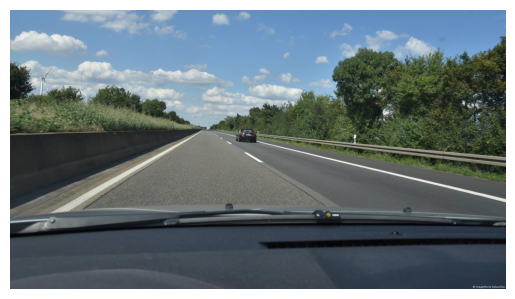

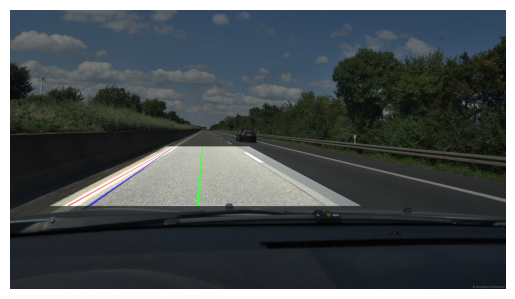

In [35]:
img = cv2.imread("../Real_Test.jpg")
ld = LaneDetector()
show(img)
show(ld.run(img))

Now we have a truely working version.
The last changes we have to do is clean up the code so it is easier to change the parameters and debug it.
(Most of the time we only want the center line and not the image.)

In [36]:
class LaneDetector():

    orig = np.array([[604, 528], [150, 759], [926, 528], [1362, 759]], dtype=np.float32)
    trans = np.array([[0, 0], [0, 600], [800, 0], [800, 600]], dtype=np.float32)
    blend_in_original = 0.5
    blend_in_edited  =  1

    white_threshold_low = 200
    white_threshold_high = 255
    white_blend_img = 0.5
    white_blend_mask = 1

    blur_kernel = (5, 5)
    
    canny_threshold_low = 50
    canny_threshold_high = 150

    hlp_rho = 1
    hlp_theta = np.pi/180
    hlp_threshold = 20
    hlp_minLineLength = 20
    hlp_maxLineGap = 500

    minimum_slope = 0.2
    one_line_middle_offset = 300
    minimum_line_spacing = 500

    middle_lane_color = (0, 255, 0)
    left_lane_color = (0, 0, 255)
    right_lane_color = (255, 0, 0)
    line_thickness = 5

    def getLinesFromImage(self, img):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        _, white_mask = cv2.threshold(img, self.white_threshold_low, self.white_threshold_high, cv2.THRESH_BINARY)
        img = cv2.addWeighted(img, self.white_blend_img, white_mask, self.white_blend_mask, 0)
        
        img = cv2.GaussianBlur(img, self.blur_kernel, 0)
        img = cv2.Canny(img, self.canny_threshold_low, self.canny_threshold_high)

        lines = cv2.HoughLinesP(img, rho = self.hlp_rho, theta = self.hlp_theta, threshold = self.hlp_threshold, 
                                minLineLength = self.hlp_minLineLength, maxLineGap = self.hlp_maxLineGap)

        return lines

    def getLanesFunctionsFromLines(self, lines):
        # average the lines to one left, one right 
        left_lines    = [] 
        left_weights  = [] 
        right_lines   = [] 
        right_weights = [] 

        for line in lines:

            x1, y1, x2, y2 = line[0] 
            if x1 == x2:
                continue

            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - (slope * x1)
            length = np.sqrt(((y2 - y1) ** 2) + ((x2 - x1) ** 2))

            if slope < 0:
                left_lines.append((slope, intercept))
                left_weights.append((length))
            else:
                right_lines.append((slope, intercept))
                right_weights.append((length))

        # return the slope and intercept or None
        ll  = np.dot(left_weights,  left_lines) / np.sum(left_weights)  if len(left_weights) > 0 else None
        rl = np.dot(right_weights, right_lines) / np.sum(right_weights) if len(right_weights) > 0 else None

        return ll, rl

    def getLaneFromLanefunction(self, img, lanefunction):
        # if the lanfunction is None (so has no lane in it)
        if lanefunction is None:
            return None
        # if the slope (so the lane) is close to horizontal
        if abs(lanefunction[0]) < self.minimum_slope:
            return None
        
        y1 = img.shape[0]
        y2 = 0

        x1 = int((y1 - lanefunction[1]) / lanefunction[0])
        x2 = int((y2 - lanefunction[1]) / lanefunction[0])
        lane = [x1, y1, x2, y2]
        
        return lane

    def getMiddleFromLanefunctions(self, img, left_lane, right_lane):
        
        if left_lane is None and right_lane is None:
            middle_lane = None
        
        # we choose a random value to set the middle line 
        # from the left or right line depending on what is present
        elif left_lane is None:
            xm1 = int(right_lane[0] - self.one_line_middle_offset)
            xm2 = int(right_lane[2] - self.one_line_middle_offset)
        elif right_lane is None:
            xm1 = int(left_lane[0] + self.one_line_middle_offset)
            xm2 = int(left_lane[2] + self.one_line_middle_offset)
        
        # if both lanes are to close to each other
        # we probebly tracked the same line twice
        elif abs(left_lane[0] - right_lane[0]) < self.one_line_middle_offset:
            
            # Now we check if the lanes are more on the left or right
            if left_lane[0] < self.minimum_line_spacing and right_lane[0] < self.minimum_line_spacing:
                xm1 = int(left_lane[0] + self.one_line_middle_offset)
                xm2 = int(left_lane[2] + self.one_line_middle_offset)
            elif left_lane[0] > self.minimum_line_spacing and right_lane[0] < self.minimum_line_spacing:
                xm1 = int(right_lane[0] - self.one_line_middle_offset)
                xm2 = int(right_lane[2] - self.one_line_middle_offset)
            # if both lanes are in the center but to close
            else:
                middle_lane = None
        
        # if we got both lanes, we can fit a middle lane through the center
        else:
            # calculate the center of both lines
            xm1 = int((left_lane[0] + right_lane[0]) / 2)
            xm2 = int((left_lane[2] + right_lane[2]) / 2)
        
        middle_lane = [xm1, 0, xm2, img.shape[0]]
        
        return middle_lane

    def run(self, img, debug=False):
        # we create a working copie, so we allways have the original image
        working_copie = img.copy()

        transformer_matrix = cv2.getPerspectiveTransform(self.orig, self.trans)
        working_copie = cv2.warpPerspective(working_copie, transformer_matrix, (int(self.trans[-1][0]), int(self.trans[-1][1])))

        # get the lines
        lines = self.getLinesFromImage(working_copie)

        ll, rl = self.getLanesFunctionsFromLines(lines)

        # get coordinats in pixels from the slope / intercept
        left_lane = self.getLaneFromLanefunction(working_copie, ll)
        right_lane = self.getLaneFromLanefunction(working_copie, rl)
        middle_lane = self.getMiddleFromLanefunctions(working_copie, left_lane ,right_lane)

        # draw on the image
        if middle_lane is None and debug is True:
            # if we found no middle lane to follow
            return None, img
        
        elif middle_lane is None and debug is False:
            return None, None
        
        elif debug is True:
            cv2.line(working_copie, (middle_lane[0], middle_lane[1]), (middle_lane[2], middle_lane[3]), self.middle_lane_color, self.line_thickness)
            if left_lane is not None:
                cv2.line(working_copie, (left_lane[0], left_lane[1]), (left_lane[2], left_lane[3]), self.left_lane_color, self.line_thickness)
            if right_lane is not None:
                cv2.line(working_copie, (right_lane[0], right_lane[1]), (right_lane[2], right_lane[3]), self.right_lane_color, self.line_thickness)
        
            transformer_matrix = cv2.getPerspectiveTransform(self.trans, self.orig)
            # the original image has the size 1920, 1080
            working_copie = cv2.warpPerspective(working_copie, transformer_matrix, (img.shape[1], img.shape[0]))
            img = cv2.addWeighted(img, self.blend_in_original, working_copie, self.blend_in_edited, 0)

            return middle_lane, img
        
        else:
            return middle_lane, None

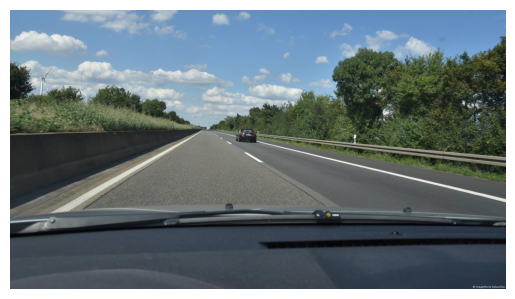

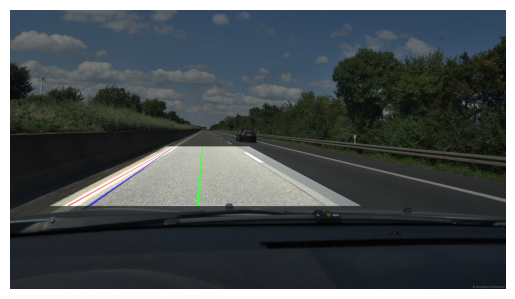

In [37]:
img = cv2.imread("../Real_Test.jpg")
show(img)

ld = LaneDetector()
middle_lane, output = ld.run(img, True)
show(output)

Now we have a more or less suficent class to test it in the game. 